In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import yt
import pickle

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble" : r'\boldmath'
})

def _plot_3x2(figsize, data, labels, cmaps, vmins, vmaxs, extent, anno, fbase="", fname="", \
              include_em_contours=False, include_SN = False, \
              cut_upper_cbars=False, cut_lower_cbars=False, infotext=""):
    # Create a figure
    fig = plt.figure(figsize=(10,10))

    Ncol=3
    Nrow=2

    dx = 0.25
    dy = 0.25
    deltax = 0.01
    deltay = 0.01

    cbardx=dx
    cbardy=0.02
    cbarpadytop = 0.03
    cbarpadybot = 0.07

    x0 = 0.05
    y0 = 0.1

    # Loop through each panel position
    i=-1
    for irow in range(Nrow-1,-1,-1):
        for icol in range(Ncol):
            i = i+1
            #i = irow*Ncol + icol
            ax = fig.add_axes([x0+icol*(dx+deltax),y0+irow*(dy+deltay),dx,dy])
            im = ax.imshow(data[i], cmap=cmaps[i], origin="lower", \
                           extent=extent, norm=LogNorm(vmin=vmins[i], vmax=vmaxs[i]))
            
            if include_em_contours and irow == 0 and icol == 0:
                # read data from pickle
                with open("datafiles/"+fbase+"-emission-contours.pkl", 'rb') as handle:
                    masks = pickle.load(handle)
                c95 = ax.contour(masks[95], levels=[0.5], colors='red', linewidths=2, extent=extent, label='95% Emissivity')
                c90 = ax.contour(masks[90], levels=[0.5], colors='orange', linewidths=2, extent=extent, label='90% Emissivity')
                c80 = ax.contour(masks[80], levels=[0.5], colors='yellow', linewidths=2, extent=extent, label='80% Emissivity')
                ax.text(20,100-30, '\\textbf{95\\% contour}', color="red")
                ax.text(20,100-15, '\\textbf{90\\% contour}', color="orange")
                ax.text(20,100-0,  '\\textbf{80\\% contour}', color="yellow")
                #ax.legend(loc="upper right")
                if include_SN:
                    point_x = (-1.03971680e+20 / 3.086e+18 + 80)
                    point_y = (-5.53008789e+20 / 3.086e+18 + 150)
                    ax.scatter(point_x, point_y, color='#5ec962', s=75, marker="o", \
                       edgecolor='white', label='Recent SN', zorder=100)
                    ax.legend(loc = "lower left")
                
            if (irow == 1) and (cut_upper_cbars == False):
                cbar_axes = fig.add_axes([x0+icol*(dx+deltax),y0+irow*(dy+deltay)+dy+cbarpadytop,cbardx,cbardy])
                cbar = plt.colorbar(im, cax=cbar_axes, orientation="horizontal", label=labels[i])
                cbar.ax.xaxis.set_label_position("top")
            if (irow == 0) and (cut_lower_cbars == False):
                cbar_axes = fig.add_axes([x0+icol*(dx+deltax),y0-cbarpadybot,cbardx,cbardy])
                cbar = plt.colorbar(im, cax=cbar_axes, orientation="horizontal", label=labels[i])
                cbar.ax.xaxis.set_label_position("bottom")
            if icol > 0:
                ax.set_yticklabels([])
            if irow > 0:
                ax.set_xticklabels([])
            if icol==0:
                ax.set_ylabel("$y~(\\mathrm{pc})$")
            if irow==0:
                if cut_lower_cbars == False:
                    ax.set_xlabel("$x~(\\mathrm{pc})$")
            ax.text(0.05, 0.9, anno[i], transform=ax.transAxes, \
                    bbox=dict(facecolor='white', edgecolor='white', boxstyle='round', alpha=0.8))
            if (irow == 1) and (icol == 0) and (infotext != ""):
                ax.text(0.95, 0.9, infotext, transform=ax.transAxes, ha="right", \
                        bbox=dict(facecolor='white', edgecolor='white', boxstyle='round', alpha=1.0))
                
                
            
    if fname == "":
        plt.show()
    else:
        fig.savefig(fname, bbox_inches="tight")

def _nuclei_density(field, data):
    return data[("gas", "number_density")] * data[("flash", "ihp ")]

# wrong!!!
#def _electron_density(field, data):
#    return data[("gas", "density")] * data[("flash", "ihp ")]


In [6]:
files = ["SILCC_hdf5_plt_cnt_1080", "SILCC_hdf5_plt_cnt_1140"]

# radius of the bubble and center
radius=120
c = ([-80, -150, 0], "pc")

for default_file in files:
    # open default file
    ds = yt.load("sim-files/"+default_file)

    # register data fields
    ds.add_field(('gas', 'H_nuclei_density'), _nuclei_density, sampling_type="local", units="cm**(-3)", force_override=True)
    ds.add_field(('gas', 'El_number_density'), _nuclei_density, sampling_type="local", units="cm**(-3)", force_override=True)

    yt.add_xray_emissivity_field(ds, 0.1, 2, metallicity=1.0, \
                                 data_dir="/Users/girichidis/Physics/Tables/yt-python/", table_type="apec")

    prj_fields = [("gas", "density"), ("gas", "xray_emissivity_0.1_2_keV"), ("gas", "El_number_density")]
    prj_names = ["coldens", "projemission", "ecoldens"]

    for f, n in zip(prj_fields, prj_names):
        data = np.array(yt.ProjectionPlot(ds, "z", center=c, fields=f).data_source.to_frb((2*radius, 'pc'), 1024)[f])
        np.save("datafiles/"+default_file+"-"+n+".npy", data)

    slc_fields = [("gas", "density"), ("gas", "temperature"), ("gas", "xray_emissivity_0.1_2_keV"), ("gas", "El_number_density")]
    slc_names = ["dens", "temp", "emis", "edens"]

    for f, n in zip(slc_fields, slc_names): 
        data = np.array(yt.SlicePlot(ds, "z", center=c, fields=f).data_source.to_frb((2*radius, 'pc'), 1024)[f])
        np.save("datafiles/"+default_file+"-"+n+".npy", data)



yt : [INFO     ] 2025-02-21 08:15:02,470 Parameters: current_time              = 340597785179995.1
yt : [INFO     ] 2025-02-21 08:15:02,472 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2025-02-21 08:15:02,473 Parameters: domain_left_edge          = [-7.715e+20 -7.715e+20 -7.715e+20]
yt : [INFO     ] 2025-02-21 08:15:02,474 Parameters: domain_right_edge         = [7.715e+20 7.715e+20 7.715e+20]
yt : [INFO     ] 2025-02-21 08:15:02,475 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-02-21 08:15:09,781 Loading emissivity data from /Users/girichidis/Physics/Tables/yt-python/apec_emissivity_v3.h5
yt : [INFO     ] 2025-02-21 08:15:09,784 X-ray emissivity data calculated with APEC 3.0.9 on 11/19/2019 by John ZuHone.
yt : [INFO     ] 2025-02-21 08:15:09,784 X-ray 'apec' emissivity data version: 3.
yt : [INFO     ] 2025-02-21 08:15:09,795 Adding ('gas','xray_emissivity_0.1_2_keV') field.
yt : [INFO     ] 2025-02-21 08:15:09,795 Adding ('gas','xray_luminosity_

yt : [INFO     ] 2025-02-21 08:16:35,516 ylim = -1234351637144348655616.000000 308648362855651344384.000000
yt : [INFO     ] 2025-02-21 08:16:35,517 Making a fixed resolution buffer of (('gas', 'El_number_density')) 800 by 800
yt : [INFO     ] 2025-02-21 08:16:35,603 Making a fixed resolution buffer of (('gas', 'El_number_density')) 1024 by 1024
yt : [INFO     ] 2025-02-21 08:16:36,007 xlim = -330.026122 170.026122
yt : [INFO     ] 2025-02-21 08:16:36,007 ylim = -400.026122 100.026122
yt : [INFO     ] 2025-02-21 08:16:36,008 xlim = -1018354206476985958400.000000 524645793523014041600.000000
yt : [INFO     ] 2025-02-21 08:16:36,008 ylim = -1234351637144348655616.000000 308648362855651344384.000000
yt : [INFO     ] 2025-02-21 08:16:36,009 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2025-02-21 08:16:36,418 Making a fixed resolution buffer of (('gas', 'density')) 1024 by 1024
yt : [INFO     ] 2025-02-21 08:16:36,523 xlim = -330.026122 170.026122
yt 

<ipython-input-25-0d041677b0f1>:49: UserWarning: The following kwargs were not used by contour: 'label'
  c95 = ax.contour(masks[95], levels=[0.5], colors='red', linewidths=2, extent=extent, label='95% Emissivity')
<ipython-input-25-0d041677b0f1>:50: UserWarning: The following kwargs were not used by contour: 'label'
  c90 = ax.contour(masks[90], levels=[0.5], colors='orange', linewidths=2, extent=extent, label='90% Emissivity')
<ipython-input-25-0d041677b0f1>:51: UserWarning: The following kwargs were not used by contour: 'label'
  c80 = ax.contour(masks[80], levels=[0.5], colors='yellow', linewidths=2, extent=extent, label='80% Emissivity')


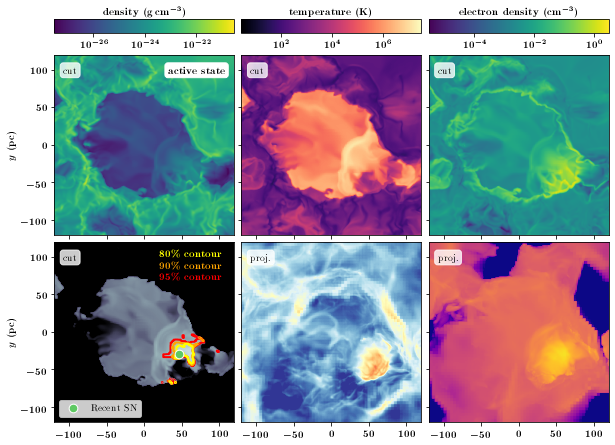

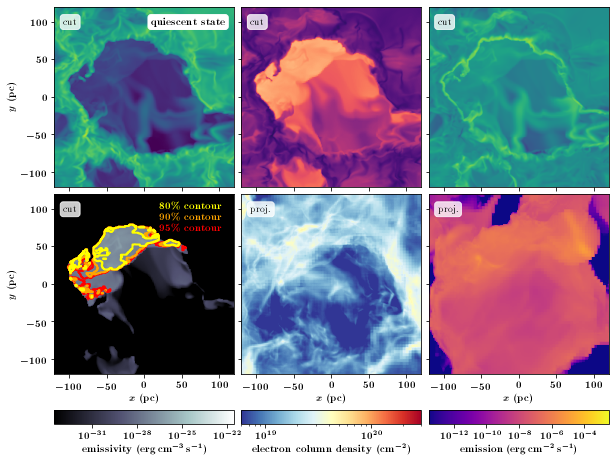

In [26]:
extent = [-radius, radius, -radius, radius]

for default_file in files:
    cold = np.load("datafiles/"+default_file+"-coldens.npy")
    dens = np.load("datafiles/"+default_file+"-dens.npy")
    temp = np.load("datafiles/"+default_file+"-temp.npy")
    emis = np.clip(np.load("datafiles/"+default_file+"-emis.npy"), 1e-35, None)
    pemi = np.clip(np.load("datafiles/"+default_file+"-projemission.npy"), 1e-15, None)
    edens = np.load("datafiles/"+default_file+"-edens.npy")
    ecold = np.load("datafiles/"+default_file+"-ecoldens.npy")

    if True:
        data = [dens, temp, edens, emis, ecold, pemi]
        anno = ["cut", "cut", "cut", "cut", "proj.", "proj."]

        labels = ["\\textbf{density }$(\\mathrm{g}\\,\\mathrm{cm}^{-3})$",
                  "\\textbf{temperature (K)}",
                  "\\textbf{electron density }$(\\mathrm{cm}^{-3})$", 
                  "\\textbf{emissivity }$(\\mathrm{erg}\\,\\mathrm{cm}^{-3}\\,\\mathrm{s}^{-1})$",               
                  "\\textbf{electron column density }$(\\mathrm{cm}^{-2})$", 
                  "\\textbf{emission }$(\\mathrm{erg}\\,\\mathrm{cm}^{-2}\\,\\mathrm{s}^{-1})$"]
        cmaps = ["viridis", "magma", "viridis", "bone", "RdYlBu_r", "plasma"]
        vmins = 0.3*np.array([1e-27, 10,  1e-5, 1e-33, 2e19, 1e-13])
        vmaxs = 3.0*np.array([1e-21, 1e7, 1,    1e-22, 1e20, 1e-3])

        if default_file == "SILCC_hdf5_plt_cnt_1080":
            include_SN = True
            cut_upper_cbars=False
            cut_lower_cbars=True
            infotext="\\textbf{active state}"
        else:
            include_SN = False
            cut_upper_cbars=True
            cut_lower_cbars=False
            infotext="\\textbf{quiescent state}"
            
        _plot_3x2((12,12), data, labels, cmaps, vmins, vmaxs, extent, anno, fbase=default_file, \
                  fname="plots/"+default_file+"-overview-plot.pdf", \
                  include_em_contours=True, include_SN=include_SN, \
                 cut_upper_cbars=cut_upper_cbars, cut_lower_cbars=cut_lower_cbars, infotext=infotext)